# Introduccion

The following study aims to perform a frequentist and Bayesian analysis on market patterns, these are often mentioned in articles as well as supposed profitable trading systems throughout the internet and even further in books that have been written in this regard.
With this I do not seek to discredit or insult anyone, but rather to shed light on this issue that has many "believers" about what is or could be the market, on the other hand much is mentioned about specific price patterns which exploit them would guarantee a profitable and operational trading when what really happens is quite another thing. The market is stochastic in nature and as will be explored throughout this study will test its mathematical nature by doing experiments that by grace anyone can take to other markets and/or instruments, ignore the statistical tools in this case is a serious mistake and in my opinion is what makes many people have faith on these patterns, as if it were something static and that has to be repeated in all markets... it is not and in fact doing the proper analysis can see how this varies depending on various factors (time-frame, instrument, period range).

# Necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
!pip install yfinance

     |████████████████████████████████| 63 kB 1.4 MB/s 
     |████████████████████████████████| 6.4 MB 8.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [4]:
import yfinance as yf

# Download historical prices of the S&P500

In [5]:
# nombre del simbolo con el cual yahoo-finance identifica al S&P500
ticker_sp500 = yf.Ticker('^GSPC')
df_data = ticker_sp500.history(period='1d', start='2018-1-1', end='2020-12-31')
df_data.drop(["Volume", "Dividends", "Stock Splits"], axis=1, inplace=True)
df_data

,Open,High,Low,Close
Date,,,,
2018-01-02,2683.729980,2695.889893,2682.360107,2695.810059
2018-01-03,2697.850098,2714.370117,2697.770020,2713.060059
2018-01-04,2719.310059,2729.290039,2719.070068,2723.989990
2018-01-05,2731.330078,2743.449951,2727.919922,2743.149902
2018-01-08,2742.669922,2748.510010,2737.600098,2747.709961
...,...,...,...,...
2020-12-23,3693.419922,3711.239990,3689.280029,3690.010010
2020-12-24,3694.030029,3703.820068,3689.320068,3703.060059
2020-12-28,3723.030029,3740.510010,3723.030029,3735.360107


# EDA - Exploratory data analysis

Let's visually check the historical prices of the S&P500

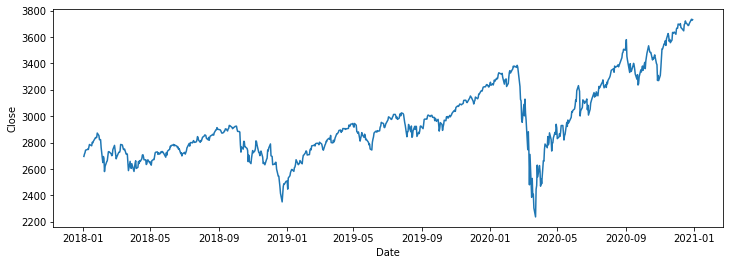

In [6]:
plt.subplots(figsize=(12, 4))
sns.lineplot(data=df_data, x=df_data.index, y='Close')
plt.show()

Before classifying sequences of patterns we need to discriminate them correctly, for this we are going to create a function that is able to obtain the "delta" of the size of the candlestick body (formed by their respective prices), this will be determined by the maximum and minimum of each price.

Delta refers to the difference (or distance) of the candlestick pattern, from its minimum to its maximum in this case.

**Delta-Type function**

In [7]:
def get_candle_type(price):
  if price["Close"] > price["Open"] : return "bullish"
  if price["Close"] < price["Open"] : return "bearish"
  #if price["Close"] == price["Open"] : return "undefined"
  return "undefined"

def set_candle_type(row):
  type_ = row["Type"]
  if type_ is "bullish":
    return row["Delta"]
  if type_ is "bearish":
    return -row["Delta"]

  return None

df_candles = pd.DataFrame()
df_candles["Delta"] = df_data["High"] - df_data["Low"]
df_candles["Type"]  = df_data.apply(lambda row: get_candle_type(row), axis=1)
df_candles["Delta"] = df_candles.apply(lambda row: set_candle_type(row), axis=1)
df_candles.dropna(axis=1)
df_candles

,Delta,Type
Date,,
2018-01-02,13.529785,bullish
2018-01-03,16.600098,bullish
2018-01-04,10.219971,bullish
2018-01-05,15.530029,bullish
2018-01-08,10.909912,bullish
...,...,...
2020-12-23,-21.959961,bearish
2020-12-24,14.500000,bullish
2020-12-28,17.479980,bullish


*Delta distribution*

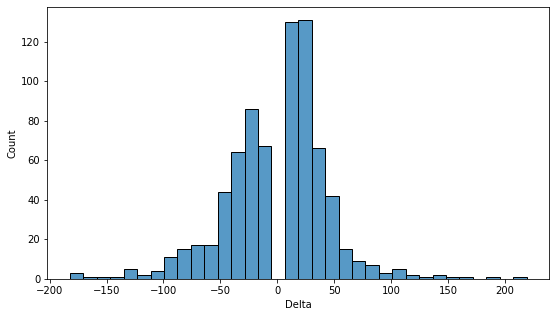

In [8]:
plt.subplots(figsize=(9,5))
sns.histplot(df_candles["Delta"])
plt.show()

*Check graphically which sentiment dominates the market; bullish or bearish?*

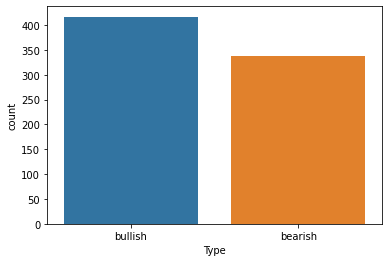

In [9]:
sns.countplot(data=df_candles, x='Type')
plt.show()

*outliers*

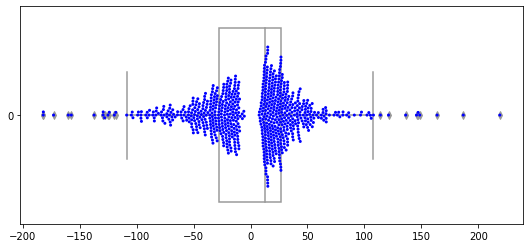

In [10]:
plt.subplots(figsize=(9, 4))
sns.boxplot(data=df_candles["Delta"], orient='h', color='white')
sns.swarmplot(data=df_candles["Delta"], size=3, orient='h', color='blue')
plt.show()

*Let's look analytically at the relevant data of the distribution.*

In [11]:
total_candles = df_candles.shape[0]
bullish_candles = df_candles["Type"][df_candles["Type"]=='bullish'].count()
bearish_candles = total_candles - bullish_candles

bullish_percent = np.round(bullish_candles/total_candles*100,2)
bearish_percent = np.round(bearish_candles/total_candles*100,2)

pd.DataFrame(data={
    'Mean': [df_candles["Delta"].mean()],
    'Std':  [df_candles["Delta"].std()],
    'Skew': [df_candles["Delta"].skew()],
    'Total-bullish':[bullish_candles],
    'Bullish(%)':[np.round(bullish_percent,2)],
    'Total-bearish':[bearish_candles],
    'Bearish(%)':[np.round(bearish_percent,2)],
    }, index=['Info']).transpose()

,Info
Mean,-0.103246
Std,46.204504
Skew,-0.202313
Total-bullish,417.000000
Bullish(%),55.230000
Total-bearish,338.000000
Bearish(%),44.770000


The conclusion on the most noticeable characteristics are:
  * The values come from a quasi-normal distribution.
  * It is sufficiently symmetric. The general rule says that if the skewness is between (-0.5, 0.5) the distribution is quasi-symmetric.
  * Existence of outliers

# Encoding patterns in strings, combinatorial analysis, filtering and optimization.

It is now when the real challenge begins, the final objective will be to create a function capable of generating probabilities on a sequence of candlesticks which will be determined by the price frequency of the market analyzed in question. But first we must ask ourselves; what kind of candles we are studying?, what do we call sequence?, is it reliable to use this word?, are its characteristics reliable and robust to volatility?, is it possible to find a pattern that we can rely on to make predictions?.

In our analysis we will look more into the latter, and perhaps incorporate new concepts as we get rid of old ideas.

**First step: rank determination criteria.**

The first objective to achieve is to generate a series of ranges that tell us what will be the size of each candlestick to study (i.e. its body), with this we mean to create a criterion that is able to determine what is the appropriate candlestick size to select according to the time series (this should apply to any asset in any time-frame), and since each of them is different because they are continuous values we must be able to generate a series of minimum-maximum intervals, otherwise an exact value will never be repeated twice, this is a property of the laws of probability.

In addition, each market has different dynamic factors (such as volatility, average historical prices, etc..) and therefore this analysis would be seriously affected if the conditions are not accurate, so the ranges would vary by having different price distributions, even within the market itself if we extend the analysis to past data and the above factors change due to different causes (crisis, cycles, fundamentals, etc..).

Recall that we start from the fact that the historical market prices form a normal distribution, and therefore we will use the standardization formula which will allow us to choose an interval using its mean and standard deviation, I will explain shortly why this is the case, for the moment let's look at the mathematical formula:

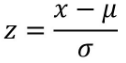

Where:
  * z(z-score) : critical value, depends on the interval chosen in the distribution.
  * x: term to be cleared, it will give us the numerical value of the interval we are looking for.
  * mu: population mean.
  * sigma: standard deviation of the population.

To select the z-value we will look at a pre-calculated table. The reason for this is simple, we will propose a constant interval and starting from it we will take different body sizes or price deltas. For this case I will take an interval of 20% (i.e. each body size will allow 20% of noise or variation, this is the accepted error), let's look at a fragment of the table for reasons of this example.

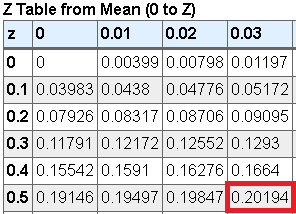

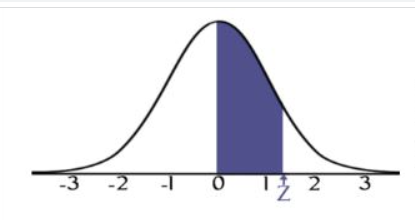

That is, starting from an interval of 20% (if we look at the red box of the table the corresponding z-value is 0.53) the successive values taken will increase according to this measure, for this example the ranges generated will be 20%, 40%, 60%, etc... Using this formula we will not depend on fixed values and with this we will have generalized the problem to any market or time scale.

Now we only need to choose a stopping criterion, i.e. taking intervals of 20% how many values can be taken as a maximum in the distribution. For this I will use 2.5 standard deviations, so the amount of ranges will be determined by the deviations we allow, if we increase the range of the candles (say to 40%) these amounts will decrease because the acceptance value is larger.

**Let's write the function:**

In [12]:
# z_critical_value = 0.53 -> valor critico del 20.194% en la tabla
def get_candles_body_range(mean, std_dev, total_devs=2.5, z_score = 0.53):
  # standarization
  # z = (x - mean)/ std_dev
  # despejamos la formula
  x = z_score*std_dev + mean
  # el punto de origen es la media
  i = mean
  intervals_ = []
  while i < std_dev*total_devs:
    intervals_.append(i)
    # nos movemos hacia la derecha de la distribucion, partiendo desde el lado derecho de la misma
    i+= x
 
  neg_intervals = []
  n_intervals = len(intervals_)
  for i in range(n_intervals - 1, 0, -1):
    neg_intervals.append(-intervals_[i])
 
  return neg_intervals + intervals_
 
bodies = get_candles_body_range(df_candles["Delta"].mean(), df_candles["Delta"].std())
total_ranges = len(bodies)
print(bodies)
print("total ranges:",total_ranges)

[-97.43731612956171, -73.05217553169632, -48.667034933830934, -24.28189433596555, -0.10324626189983444, 24.28189433596555, 48.667034933830934, 73.05217553169632, 97.43731612956171]
total ranges: 9


As can be seen we do not integrate the function to obtain the value of z and based on that calculate each iteration of X, instead we calculate once the 20% range and from there on all the increments for X will be uniform (based on the initial value of the formula).

This will give us more ranges than if we use intervals determined by z (integrating the Gaussian probability function), since these would increase to 100% which corresponds to the right tail of the distribution. Following the inverse logic they would end up at 0% for the left tail of the distribution (because they will be negative values).

Another important detail to keep in mind is that we calculated the ranges in two parts; first the positive and then the negative (symmetric), finally these generated lists were merged into a single one which contains all the ranges...

A more detailed explanation of this will be given in the optional *calculation of price ranges* section.

As mentioned at the beginning the formula cleared is the standardization, with this we obtain X (which represents an observation) and thus determine the numerical interval which gives us the range. We should also mention that these can be negative since they correspond to bearish candles! Now we need a function that generates intervals from the calculated ranges.


Remark: *When we finish our study this formula will be modified to generalize any type of interval without the need to look at a pre-calculated z-table, for the moment we do it this way for learning purposes.*

**Interval coding**.

The next step will be to encode or encrypt the generated ranges in order to form the candlestick patterns in a simpler way, I will create an algorithm that generates only letters for each distinct continuous value, although the symbology is indifferent.

In [13]:
def encrypt(bodies):
  letters = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

  n_letters = len(letters)
  n_bodies= len(bodies)
  i = 0
  idx= 0
  level = 1
  code = {}
  while idx < n_bodies:
    if i >= n_letters:
      i = 0
      level+= 1
    c = ''
    for _ in range(level):
      c+= letters[i]
    code[c] = bodies[idx]
    i+= 1
    idx+= 1

  return code

encripted_bodies = encrypt(bodies)
print(encripted_bodies)

{'A': -97.43731612956171, 'B': -73.05217553169632, 'C': -48.667034933830934, 'D': -24.28189433596555, 'E': -0.10324626189983444, 'F': 24.28189433596555, 'G': 48.667034933830934, 'H': 73.05217553169632, 'I': 97.43731612956171}


At this point we need a function that is able to take the ranges and transform them into intervals, with this we will form pairs of lows and highs. In this way we will be able to permute them to create the sequences that will represent the different types of candlestick bodies, i.e. different combinations of price ranges that the market can generate according to our estimates.

This is not a simple problem in computational terms, in fact it is *variations with repetition* and is studied in combinatorics. So as the strings become larger in length the computational cost will grow exponentially, let's understand the following; what we are looking for is to evaluate *all the existing possibilities* of combinations of intervals or parameters, this is a brute force problem. 
Before programming the functions for this task we will resort to the mathematical expression.

**Variations with repetition**

variaciones_con_repeticion.png

Formal definition: *each of the tuples that can be formed by taking elements of a set is called a variation. In finite set combinatorics it is often necessary to know the number of variations of a set of m elements taken in tuples of n elements (with or without repeated elements in the tuples). The variations with repetition of sets of m elements taken in n-element tuples is the number of different n-tuples of a set of m elements.*

It sounds confusing, however it is simpler if we evaluate it with an example, for our first case we will look for even sequences (of 2 elements). We must remember that in total we have X possible ranges generated by the function **get_candles_body** (remember that this value will change if we use more standard deviations, which is equivalent to say that we take more intervals). Then following the formula we will have the following amount of possible combinations for our intervals:

VR(9, 2) = 9^2 = 81.

The result of VR(m, n) will be the number of possible two-letter elements that we can form.  These will represent the even intervals of candlesticks such as: {AB, AC, AB, AA, BB, ...}.

To generate these pairs or intervals I will use the itertools library, this will save us work and lines of code. Let's write the function.

In [14]:
from itertools import product

def generate_minmax_intervals(letters):
  return [item for item in product(letters, repeat=2)]

minmax_intervals = generate_minmax_intervals(encripted_bodies.keys())
print(minmax_intervals[:15])
print("total intervals:", len(minmax_intervals))

[('A', 'A'), ('A', 'B'), ('A', 'C'), ('A', 'D'), ('A', 'E'), ('A', 'F'), ('A', 'G'), ('A', 'H'), ('A', 'I'), ('B', 'A'), ('B', 'B'), ('B', 'C'), ('B', 'D'), ('B', 'E'), ('B', 'F')]
total intervals: 81


Doing a "print" to the result of the function we will be able to evaluate the amount of formed even combinations, this is just what we wanted.

Before continuing with the next step I must say that we are already in conditions to understand mathematically the reason of this, I will repeat something that I already mentioned previously;

```we need even intervals because they represent the size of the body of each candlestick pattern to be studied regardless of how many candlesticks our future pattern chains have, although we may only be interested in evaluating the number of times a particular candlestick repeats, and by doing this we will get any study to do with patterns.```

On the other hand the term "minimum and maximum" refers to the allowed "error", i.e. the minimum where our candlestick starts and its maximum bounded. If we say as an example that a candle is of the form (20, 80), this translates as follows: its body can be formed by a distance that varies between: 20 <= X <= 80 units, with this we infer that any continuous value between that range is allowed, as an example if a price delta has a value of 70 this would be accepted because it is within that interval, however 10 or 90 not, so it would be rejected... this seems very obvious but I wanted to emphasize it for the last time. This reasoning also applies to negative intervals which will represent bearish candlesticks.

**Interval filtering**

Before generating the sequences or chains that finally will serve us to study its frequency in the market, we must reason the following; not all the intervals are valid, although with our formula we could calculate the total of possible intervals, in this context it is not true to say that all will be useful to us. For example where the minimum of a candle starts can never be a maximum, therefore if A < B a candle interval allowed would be (A,B), but it could never be (B, A) because this is meaningless...

The criteria used will be as follows:
  * If the value is positive and MIN < MAX then the interval is accepted, otherwise it will be rejected and discarded. For the negative case the logic is the inverse.
  * If the value is negative and MAX > MIN then the value is accepted, otherwise rejected. Recall that the closed interval notation is [MIN, MAX]. In addition the function will take an additional parameter that we must not forget, the dictionary that stored the information of the coding that we did in the initial steps, it contains the continuous value that represents each letter.

In [15]:
def filter(encripted_bodies, intervals):
  intervals_ = []
  for i in intervals:
    min_ = encripted_bodies[i[0]]
    max_ = encripted_bodies[i[1]]
    if min_ >= 0:
      if min_ >= max_:
        continue
    else:
      if max_ <= min_:
        continue
    
    intervals_.append(i)
  return intervals_

total_intervals = len(minmax_intervals)
minmax_intervals = filter(encripted_bodies, minmax_intervals)
print(minmax_intervals)
print("total intervals:", len(minmax_intervals))

[('A', 'B'), ('A', 'C'), ('A', 'D'), ('A', 'E'), ('A', 'F'), ('A', 'G'), ('A', 'H'), ('A', 'I'), ('B', 'C'), ('B', 'D'), ('B', 'E'), ('B', 'F'), ('B', 'G'), ('B', 'H'), ('B', 'I'), ('C', 'D'), ('C', 'E'), ('C', 'F'), ('C', 'G'), ('C', 'H'), ('C', 'I'), ('D', 'E'), ('D', 'F'), ('D', 'G'), ('D', 'H'), ('D', 'I'), ('E', 'F'), ('E', 'G'), ('E', 'H'), ('E', 'I'), ('F', 'G'), ('F', 'H'), ('F', 'I'), ('G', 'H'), ('G', 'I'), ('H', 'I')]
total intervals: 36


As we see our function included the equal in the Min and Max conditionals, this is because we also want to filter the values of repeated intervals, for example; (A,A), (B,B), etc.... If the interval were exactly the same on both sides this will be the same as looking for our candle body to have the same value, for example if A = 50 and we have (A,A) then the equivalent is (50, 50) so the candle value to look in the market should be exactly equal to that value (this is equivalent to say that there are no intervals, because being equal minimum and maximum the error allowed by logic will be 0). In a continuous scale this is practically impossible, as well demonstrated by the laws of probability...

Let's see how many intervals we manage to reduce with our filter function

In [16]:
print("filtered intervals:", np.abs(len(minmax_intervals)-total_intervals))

filtered intervals: 45


**Chain coding**.

For the moment we only generate the intervals that represent the allowed limits of the body of our candle, now we only have to form the patterns (i.e. the chains of candles) determined by the length that we choose. This is the most complex part in computational terms and although we already noticed this, it is time to repeat once again the formula studied in combinatorics.
Let's see the formula of how many possible candlestick chains we can form given a number of total intervals:

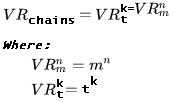

Let's see what each thing means:
  * VR(m, n) : Total intervals created, for example {AA, BA, BB, AC, CC, ...}, we saw this formula in a previous analysis.
  * VR(t, k): Total possible chains given the total number of available intervals.

This becomes fast and excessively expensive even if our combination of generated intervals is small, luckily the **filter** function helped us in this respect by optimizing only the most relevant values. If we did not use this function the actual value of strings would be titanic. Let's see a brief example:

In [17]:
def calculate_total_chains(chains_len, total_ranges):
  total_intervals = total_ranges**2
  return total_intervals**chains_len

calculate_total_chains(3, 9)

531441

If we assume that we generate 9 price ranges this would give us a total of 81 possible intervals (remember that the exponent is 2 because the intervals are even), with this we can form the chains or sequences of market patterns to study, let's make the following calculations.

The number of candlestick patterns that we can form by increasing the length of the candlestick sequences or chains are:
  * If X_chains=2 : 81^2 = 6561
  * If X_chains=3 : 81^3 = 531441
  * If X_chains=4 : 81^4 = 43046721
  * If X_chainsc=5 : 81^5 = 3486784401

That is, if we only have 81 price intervals (min, max) and we want to analyze a sequence or chain of 3 candlestick patterns, for example: {(AA, AB, BC), (AB, AA, CC), Etc...} we would end up with a total of 531441 possible combinations!!!, extremely expensive!!!(not to mention for chains of length 4 and 5...).

That is, if we had not optimized the number of intervals using the **filter** function, the total number of intervals would be (I^2)^N_Chains, which would reduce the complexity of our problem.

**String generator function**

Finally we are able to generate our strings for further market analysis, for the simplest example I will use strings of 3 patterns in length. Let's write the function.

In [18]:
def generate_chains(intervals, chain_len):
  intervals_ = []
  chains = []
  for p in intervals:
    intervals_.append(str(p[0]+p[1]))

  for c in product(intervals_, repeat = chain_len):
    chains.append(c)
  return chains

chains = generate_chains(minmax_intervals, 3)
print(chains[:15])
print("total chains:", len(chains))

[('AB', 'AB', 'AB'), ('AB', 'AB', 'AC'), ('AB', 'AB', 'AD'), ('AB', 'AB', 'AE'), ('AB', 'AB', 'AF'), ('AB', 'AB', 'AG'), ('AB', 'AB', 'AH'), ('AB', 'AB', 'AI'), ('AB', 'AB', 'BC'), ('AB', 'AB', 'BD'), ('AB', 'AB', 'BE'), ('AB', 'AB', 'BF'), ('AB', 'AB', 'BG'), ('AB', 'AB', 'BH'), ('AB', 'AB', 'BI')]
total chains: 46656


We will continue this study in the **Chain Generator Class** section where we will formalize the concepts learned in a class, and add what is necessary to continue with our market analysis.

# Normal distribution: Calculation of price ranges

This section is not necessary to complete our study it is interesting the notion of ranges and intervals taken by our function. Let's remember that after all, this will be used to combine and form candlestick intervals, which will finally form the market patterns we are looking for.

In the previous section we saw the **get_candles_body_range** function, which was incomplete. Now we will use the python scipy module to calculate the z-score independently and generalize our formula for any interval we take.

In [19]:
import scipy.stats as st

def get_candles_body_range_2(mean, std_dev, interval_percent=0.2, total_devs=2):
  # standarization
  # z = (x - mean)/ std_dev
  z_score = st.norm.ppf(0.5 + interval_percent/2)
  x = z_score*std_dev + mean
  # el punto de origen es la media
  i = x
  intervals_ = []
  while i < std_dev*total_devs:
    intervals_.append(i)
    i+= x
 
  neg_intervals = []
  n_intervals = len(intervals_)
  for i in range(n_intervals - 1, 0, -1):
    neg_intervals.append(-intervals_[i])
 
  return neg_intervals + intervals_
 
bodies = get_candles_body_range(df_candles["Delta"].mean(), df_candles["Delta"].std(), 0.2)
total_ranges = len(bodies)
print(bodies)
print("total ranges:",total_ranges)

[-0.10324626189983444]
total ranges: 1


If we look at the formula we will also observe the following:

**st.norm.ppf(0.5 + *interval_percent/2*)**

Where:
  * interval_percent/2: is our chosen interval percentage, and on which the interval expansion will base its increment, it is divided by 2 because the distribution starts at 0(left tail end) and ends at 1(right tail end) so if we choose an interval of 0.5 we will have reached the end of the distribution and the calculations would be overrun.
  * **0.5** represents the z-score of the mean value of the normal distribution (remember that it is defined as N(0, 1)), so we start from there (adding our interval) because z for this value is 0 which makes sense with the value of the mean for the standardized distribution when we isolate the formula...
  
let's do a simple test. To continue with the previous example the intervals will be 20%...

In [20]:
i = 0.2
x = 0
run = True
while run:
  if (0.5 + x) >= 1.0:
    # nos acercamos al 1.0.
    x= 0.49
    run = False
  print("z-score:{} interval-percent:{}".format(st.norm.ppf(0.5 + x), 0.5+x))
  x+= i

z-score:0.0 interval-percent:0.5
z-score:0.5244005127080407 interval-percent:0.7
z-score:1.2815515655446004 interval-percent:0.9
z-score:2.3263478740408408 interval-percent:0.99


As we can see the increments were from 0.5 to 1.0 (actually we used an approximate value, otherwise the result would have been +Inf), these represent the z-scores for intervals of 20%, 40%, 60%, etc...

The logic for negative values is similar, let's see it.

In [21]:
i = 0.2
x = 0.0
run = True
while run:
  if (0.5 + x) <= 0.0:
    # nos acercamos al 0.0.
    x= -0.49
    run = False
  print("z-score:{} interval-percent:{}".format(st.norm.ppf(0.5 + x), 0.5 + x))
  x-= i

z-score:0.0 interval-percent:0.5
z-score:-0.5244005127080409 interval-percent:0.3
z-score:-1.2815515655446004 interval-percent:0.09999999999999998
z-score:-2.3263478740408408 interval-percent:0.010000000000000009


Exactly the same... only the interval decreased from -20% to -20% and the z-score now has a negative sign.

# Chain Generator Class

In the section on *Encoding patterns...* we studied and reasoned all the elements to incorporate if we want to generate sequences or chains of candlesticks in any type of market and regardless of its conditions or time frame. We saw the meaning of ranges, intervals and using coding and optimization we finally concluded a robust combinatorial analysis. However this is not all, to complete our study we must be able to decode these sequences and use them so that we can calculate the frequency of these patterns in the market.

In the following, we will recapitulate what we have seen in a class that does all of this and will also have a decoding and predictive function.

In [22]:
import scipy.stats as st
from itertools import product

class PatternsChainsGenerator:
  def __init__(self, df, body_interval=0.4, n_std=2):
    self.__x = None
    self.__body_ranges = self.__generate_candles_body_range(df, body_interval, n_std)
    self.__body_ranges_dict = None
    self.__body_intervals_n = None
    self.__chains_n = None
    self.__body_intervals = None
    self.__body_intervals_optimized = None
    self.__chains = None

  def __generate_candles_body_range(self, df, interval_percent, n_std):
    # standarization
    # z = (x - mean)/ std_dev
    def standarization(z_score, mean, std_dev):
      return z_score*std_dev + mean

    mean      = df.mean()
    std_dev   = df.std()
    z_score   = st.norm.ppf(0.5 + interval_percent/2)
    self.__x  = standarization(z_score, mean, std_dev)
    pos_intervals_x = []
    x = 0
    while x < std_dev*n_std:
      pos_intervals_x.append( x )
      x+= self.__x
    
    neg_intervals_x = []
    n_intervals = len(pos_intervals_x)
    for i in range(n_intervals - 1, 0, -1):
      neg_intervals_x.append(-pos_intervals_x[i])
    
    return neg_intervals_x + pos_intervals_x

  def get_interval_increment(self):
    return self.__x

  def __encrypt_body_ranges(self):
    letters = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

    n_letters = len(letters)
    n_bodies= len(self.__body_ranges)
    i = idx= 0
    level = 1
    code = {}
    while idx < n_bodies:
      if i >= n_letters:
        i = 0
        level+= 1
      c = ''
      for _ in range(level):
        c+= letters[i]
      code[c] = self.__body_ranges[idx]
      i+= 1
      idx+= 1

    return code

  def __generate_minmax_intervals(self, letters):
    return [item for item in product(letters, repeat=2)]

  def __filter(self, encripted_bodies_dict, intervals):
    intervals_ = []
    for i in intervals:
      # desencriptamos
      min_ = encripted_bodies_dict[i[0]]
      max_ = encripted_bodies_dict[i[1]]
      if min_ >= 0:
        if min_ >= max_:
          continue
      else:
        if max_ <= min_:
          continue
      
      intervals_.append(i)
    return intervals_

  def __join_intervals(self, body_intervals):
    body_intervals_ = []
    for i in body_intervals:
      body_intervals_.append(str(i[0]+i[1]))
    return body_intervals_

  def __generate_chains(self, body_intervals_cod, chain_len):
    chains = []
    for c in product(body_intervals_cod, repeat = chain_len):
      chains.append(c)
    return chains

  def __decrypt(self, body_ranges_dict, chains, chain_len):
    decrypted_chain = []
    for c in chains:
      chain = []
      for l in range(chain_len):
        interval = c[l]
        chain.append((body_ranges_dict[interval[0]],body_ranges_dict[interval[1]]))
      decrypted_chain.append(chain)
    return decrypted_chain

  def predict(self, chain_len):
    self.__body_ranges_dict = self.__encrypt_body_ranges()
    minmax_intervals = self.__generate_minmax_intervals(self.__body_ranges_dict)
    self.__body_intervals = self.__filter(self.__body_ranges_dict, minmax_intervals)
    self.__body_intervals_n = len(self.__body_intervals)
    self.__body_intervals_optimized = np.abs(self.__body_intervals_n - len(minmax_intervals))

    body_intervals_joined = self.__join_intervals(self.__body_intervals)

    self.__chains = self.__generate_chains(body_intervals_joined, chain_len)
    self.__chains_n = len(self.__chains)
    return self.__decrypt(self.__body_ranges_dict, self.__chains, chain_len)

  def info(self):
    return pd.DataFrame(data={'total-intervals':[self.__body_intervals_n], 'total-chains':[self.__chains_n], 'total-intervals-optimized':[self.__body_intervals_optimized]}, index=['info']).transpose()
  def get_intervals(self):
    return pd.DataFrame(data={'Min':[min_[0] for min_ in self.__body_intervals], 'Max':[max_[1] for max_ in self.__body_intervals]})
  def get_chains(self):
    return self.__chains
  def get_ranges_dict(self):
    return self.__body_ranges_dict

As an additional step we will store the value of X, which is the increment value of the interval(s). This value is very important and in the next section I will explain why and how we will use it. For the moment let's continue.

In [23]:
p_candles = PatternsChainsGenerator(df_candles["Delta"])
p_chains = p_candles.predict(chain_len=3)

Let's look at all the possible delta price ranges

In [96]:
p_chains[:15]

[[(-72.37925720290649, -48.25283813527099),
  (-72.37925720290649, -48.25283813527099),
  (-72.37925720290649, -48.25283813527099)],
 [(-72.37925720290649, -48.25283813527099),
  (-72.37925720290649, -48.25283813527099),
  (-72.37925720290649, -24.126419067635496)],
 [(-72.37925720290649, -48.25283813527099),
  (-72.37925720290649, -48.25283813527099),
  (-72.37925720290649, 0)],
 [(-72.37925720290649, -48.25283813527099),
  (-72.37925720290649, -48.25283813527099),
  (-72.37925720290649, 24.126419067635496)],
 [(-72.37925720290649, -48.25283813527099),
  (-72.37925720290649, -48.25283813527099),
  (-72.37925720290649, 48.25283813527099)],
 [(-72.37925720290649, -48.25283813527099),
  (-72.37925720290649, -48.25283813527099),
  (-72.37925720290649, 72.37925720290649)],
 [(-72.37925720290649, -48.25283813527099),
  (-72.37925720290649, -48.25283813527099),
  (-48.25283813527099, -24.126419067635496)],
 [(-72.37925720290649, -48.25283813527099),
  (-72.37925720290649, -48.25283813527099)

Let's see all the possible coded intervals (the intervals representing the Minimum-Maximum of each candlestick pattern)

In [25]:
p_candles.get_intervals()

,Min,Max
0,A,B
1,A,C
2,A,D
3,A,E
4,A,F
5,A,G
6,B,C
7,B,D
8,B,E
9,B,F


List of decoded ranges, these are used to form the delta price intervals.

In [26]:
p_candles.get_ranges_dict()

{'A': -72.37925720290649,
 'B': -48.25283813527099,
 'C': -24.126419067635496,
 'D': 0,
 'E': 24.126419067635496,
 'F': 48.25283813527099,
 'G': 72.37925720290649}

Let's see all the possible strings that can be formed, this is the same information seen in the first step but without decoding

In [27]:
pd.DataFrame(data=p_candles.get_chains())

,0,1,2
0,AB,AB,AB
1,AB,AB,AC
2,AB,AB,AD
3,AB,AB,AE
4,AB,AB,AF
...,...,...,...
9256,FG,FG,DF
9257,FG,FG,DG
9258,FG,FG,EF
9259,FG,FG,EG


If we check the basic information we can also observe the amount of total string combinations (applying the filter function and optimizing the equal intervals). Also the total intervals used to create these strings, i.e. those used for the permutations that form them after applying the optimization, and finally we see how much is this optimized quantity.

In [28]:
p_candles.info()

,info
total-intervals,21
total-chains,9261
total-intervals-optimized,28


For strings of only length=3 the possible combinations are immense, this already anticipates how improbable it can be to find a specific string (even if we seek to maximize a sequence of patterns).

Despite the optimization applied we see that it is still not enough, so we will calculate this in a more efficient way making use of the laws of probability and mathematics, all this in the next section!

# Introduction to pattern probability analysis on the S&P500.

From this moment on we are able to implement the necessary routines to study the market. We will complement everything seen so far, creating a new class which will be our base to study the market patterns, this will allow us to calculate the frequencies or probabilities using the *Laplace* rule and from there we will classify the different chains of patterns that we can create forming a matrix.

**Laplace Probability Rule**

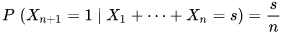

This is equivalent to calculating the *amount of given events* over the *amount of observations or total events*.

We will implement this in our class, in addition to a function that will store in a dictionary the type of pattern with its frequency.

In [29]:
def compute_patterns_probs(df_candles, body_interval=0.4, n_std=2):
  def is_bound(value, interval):
    return (value >= interval[0] and value <= interval[1])
  def laplace_rule(matches, observations):
    return matches/len(observations)

  bodies = df_candles.values
  patterns = PatternsChainsGenerator(df_candles)
  patterns_intervals = patterns.predict(chain_len=1)
  intervals_dict = {}
  for p in patterns_intervals:
    pattern_interval = p[0]
    matches = 0
    for b in bodies:
      if is_bound(b, pattern_interval):
        matches+= 1
      
    intervals_dict[pattern_interval] = laplace_rule(matches, bodies)
      
  return intervals_dict

As we can see the nested loop calculates the frequency of each pattern generated by the function *predict* of the class **PatternsChainsGenerator**, these are the intervals that will be used to classify such patterns given all the previously calculated market bodies (price deltas), this task will be taken care of by the main loop. We also note that the parameter used is a string of length 1, thus the generated strings will be of an interval which will allow us to study individually each pattern and its characteristics along with its frequency or probability.

Let's test the function by giving as parameter the dataframe created at the beginning of our analysis.

In [30]:
compute_patterns_probs(df_candles["Delta"])

{(-72.37925720290649, -48.25283813527099): 0.060927152317880796,
 (-72.37925720290649, -24.126419067635496): 0.21589403973509932,
 (-72.37925720290649, 0): 0.38543046357615895,
 (-72.37925720290649, 24.126419067635496): 0.6370860927152318,
 (-72.37925720290649, 48.25283813527099): 0.8503311258278146,
 (-72.37925720290649, 72.37925720290649): 0.9019867549668874,
 (-48.25283813527099, -24.126419067635496): 0.15496688741721854,
 (-48.25283813527099, 0): 0.32450331125827814,
 (-48.25283813527099, 24.126419067635496): 0.5761589403973509,
 (-48.25283813527099, 48.25283813527099): 0.7894039735099337,
 (-48.25283813527099, 72.37925720290649): 0.8410596026490066,
 (-24.126419067635496, 0): 0.1695364238410596,
 (-24.126419067635496, 24.126419067635496): 0.42119205298013246,
 (-24.126419067635496, 48.25283813527099): 0.6344370860927152,
 (-24.126419067635496, 72.37925720290649): 0.686092715231788,
 (0, 24.126419067635496): 0.25165562913907286,
 (0, 48.25283813527099): 0.4649006622516556,
 (0, 72.

This is interesting, we can observe that certain intervals that form the acceptance pattern have in fact a very high frequency, ranging from almost 70% to 90%, remember that the intervals used are 20% (i.e. 40%/2 according to the calculations of the standardization formula).

It is right here that we must make a revision, these values are not casual. In fact it can be mistakenly thought that we are in front of the holy grail of the patterns and therefore assume an expert trading system, we will demonstrate that this is not so easy .... **and we are far from it**.

In order to understand the above mentioned we must emphasize (and repeat) the following; *A pattern is nothing more than an acceptance interval, so we defined it and based on that notion we created a criterion which allowed us to accept values depending on the value of the price ratio.For this we used the concept of "error", since after all this is what the intervals symbolize.*

So the values that have a high probability are nothing but excessively open intervals, and even so wide in range that they accept both positive and negative values. To solve this we need another filter function which will eliminate those intervals that cross a certain gap, this will be proposed below along with its class.

**Implementation of the class for pattern validation**.

In [31]:
class PatternsEngine(PatternsChainsGenerator):
  def __init__(self, df_candles, body_interval=0.4, n_std=2):
    PatternsChainsGenerator.__init__(self, df_candles, body_interval, n_std)
    self.__df_candles = df_candles

  def __compute_patterns_probs(self):
    def is_bound(value, interval):
      return (value >= interval[0] and value <= interval[1])
    def laplace_rule(matches, observations):
      return matches/len(observations)

    bodies = self.__df_candles.values
    patterns_intervals = self.predict(chain_len=1)
    intervals_dict = {}
    for p in patterns_intervals:
      pattern_interval = p[0]
      matches = 0
      for b in bodies:
        if is_bound(b, pattern_interval):
          matches+= 1
      
      intervals_dict[pattern_interval] = laplace_rule(matches, bodies)
      
    return intervals_dict
  
  def compute(self):
    patterns_probs = self.__compute_patterns_probs()
    x_increment = self.get_interval_increment()
    valid_patterns_probs = {}
    for p in patterns_probs.keys():
      # si el delta de la vela esta dentro del rango de aceptacion...
      if np.abs(p[0] - p[1]) <= x_increment:
        valid_patterns_probs[p] = patterns_probs[p]
    return valid_patterns_probs

pse = PatternsEngine(df_candles["Delta"])
patterns = pse.compute()
patterns

{(-72.37925720290649, -48.25283813527099): 0.060927152317880796,
 (-48.25283813527099, -24.126419067635496): 0.15496688741721854,
 (-24.126419067635496, 0): 0.1695364238410596,
 (0, 24.126419067635496): 0.25165562913907286,
 (24.126419067635496, 48.25283813527099): 0.21324503311258278,
 (48.25283813527099, 72.37925720290649): 0.051655629139072845}

We see how our class calls an additional function (which was implemented in the *Encoding patterns* section), this is **get_interval_increment** which returns the increment value of each generated interval. Recall that this was calculated in previous steps using the standardization function.

Now it makes sense, as we can see the probabilities dropped drastically(when reducing the distance of the intervals)... this was expected and now we understand why. Let's sort this information in a dataframe.

In [32]:
df_patterns = pd.DataFrame(data=patterns.keys())
df_patterns = df_patterns.rename(columns={0: "Min", 1: "Max"})
df_patterns['Prob'] = patterns.values()
df_patterns.sort_values(by='Prob', ascending=False, inplace=True, ignore_index=True)
df_patterns

,Min,Max,Prob
0,0.000000,24.126419,0.251656
1,24.126419,48.252838,0.213245
2,-24.126419,0.000000,0.169536
3,-48.252838,-24.126419,0.154967
4,-72.379257,-48.252838,0.060927
5,48.252838,72.379257,0.051656


Let's make a plot on the best probabilities found

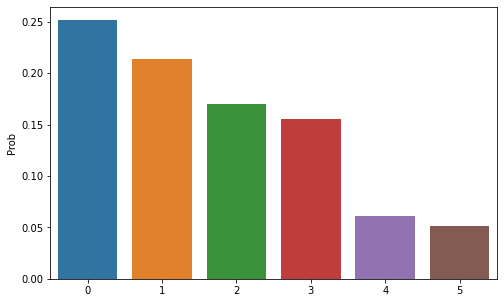

In [33]:
plt.subplots(figsize=(8, 5))
sns.barplot(data=df_patterns, x=df_patterns.index, y='Prob')
plt.show()

As we can see this graph gives us a visual reference of how many probabilities we calculate, X axis represents the total intervals and Y axis the frequency or probability.

# Probability chains for independent stochastic events

To be able to fully model the probability chains in the market we must first understand some notions about probability, these play a fundamental role in our search and have something important to tell us, so let's start with the definition of probability for independent events.

```It is said that random events are independent of each other when the probability of each of them is not influenced by the occurrence or not of the other, i.e. the events are not related in any way. In probability theory this rule is expressed as follows:```

multiple_independent_events.png

For example given Ai={{A1, A2, ... , An} if these are independent their joint probability (the intersection of the events) is the product of the probabilities.

For only two events this simple rule is summarized as (which is how it is usually studied):

independent_events.png

Taking this theory to the market we will say that A and B represent a certain candlestick pattern (their characteristics at this time are irrelevant), then if we want to know what is the probability of a chain of events or pattern events we must first calculate the probability of each of them separately and then multiply chain by chain to obtain their respective probabilities. This is easy to put into practice, the big flaw is the following; being independent events the order of the sequence will be irrelevant and therefore it would be the same to calculate a chain of type AAB, ABA or BAA (where each letter represents a different candle pattern), since the order of the multiplication is commutative, using the property of intersection of events in the example we would have;

P(AAB) = P(BAA) = P(A)xP(A)xP(B) = P(B)xP(A)xP(A).

```Due to the studies done so far we were able to prove that this is not true, the order for our model is fundamental since each chain will have a different likelihood ratio and therefore if we base our calculations on the independence of events we should ignore such order. As a result, apparently different chains will have the same probability of occurrence in common, and as said before this makes no real sense in markets. However, it is not all a lie, because we do not have a theory that necessarily affirms or refutes that the closing of a price A implies the formation of a future price B, and in fact thanks to the Markovian property we can treat the market as a stochastic process without memory, therefore an event A does not necessarily imply an event B. We will discuss this in the section on the probability of dependent events, however it must be exposed the great flaw of modeling the market only by applying this form.```

**Coding the intervals to calculate the probability matrix.**

The first step will be to code the intervals (recycling some of the functions we already created) in order to form the chains of independent events.

In [34]:
def encrypt_intervals(patterns_dict):
  letters = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

  n_letters = len(letters)
  n_bodies= len(bodies)
  i = 0
  level = 1
  code = {}
  for p in patterns_dict.values():
    if i >= n_letters:
      i = 0
      level+= 1
    c = ''
    for _ in range(level): c+= letters[i]
    code[c] = p
    i+= 1

  return code

pse = PatternsEngine(df_candles["Delta"])
patterns = pse.compute()
encoded_patterns = encrypt_intervals(patterns)
encoded_patterns

{'A': 0.060927152317880796,
 'B': 0.15496688741721854,
 'C': 0.1695364238410596,
 'D': 0.25165562913907286,
 'E': 0.21324503311258278,
 'F': 0.051655629139072845}

This function gives us as a result a dictionary of probabilities sorted by letters, which represent the 'coded' values that we will use to generate the probability strings. Let's use the combinatorics and store the results in a pandas data frame(just for a better visual aspect).

In [35]:
def encoded_pattern_chains(encoded_patterns, chain_len):
  return pd.DataFrame(data=[item for item in product(encoded_patterns.keys(), repeat=chain_len)])

enconded_chains = encoded_pattern_chains(encoded_patterns, 3)
enconded_chains

,0,1,2
0,A,A,A
1,A,A,B
2,A,A,C
3,A,A,D
4,A,A,E
...,...,...,...
211,F,F,B
212,F,F,C
213,F,F,D
214,F,F,E


Finally we can generate the probability matrix of the sequences or events. Let's implement all this plus the decoder function in a class.

In [36]:
class IEChains():
  def __init__(self, patterns):
    self.__patterns_dict = patterns

  def __encrypt_intervals(self):
    letters = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

    n_letters = len(letters)
    n_bodies= len(bodies)
    i = 0
    level = 1
    code = {}
    for p in self.__patterns_dict.values():
      if i >= n_letters:
        i = 0
        level+= 1
      c = ''
      for _ in range(level): c+= letters[i]
      code[c] = p
      i+= 1

    return code
  
  def __encoded_pattern_chains(self, encoded_patterns, chains_len):
    return [item for item in product(encoded_patterns.keys(), repeat=chains_len)]

  def predict(self, chains_len):
    enc_patterns = self.__encrypt_intervals()
    enc_patterns_chains = self.__encoded_pattern_chains(enc_patterns, chains_len)
    patts_names = []
    probs_ = []
    for p in enc_patterns_chains:
      name = ''
      probs = 1
      for n in p:
        name+= n
        probs*= enc_patterns[n]
      patts_names.append(name)
      probs_.append(probs)

    return pd.DataFrame(data={'pattern':patts_names, 'ind-probability':probs_})

Let's compile the class and build the object with the single string length parameter of 3(as in our example).

In [37]:
ind_events_chains= IEChains(patterns)
chain_len = 3
df_ipatterns = ind_events_chains.predict(chain_len)
df_ipatterns

,pattern,ind-probability
0,AAA,0.000226
1,AAB,0.000575
2,AAC,0.000629
3,AAD,0.000934
4,AAE,0.000792
...,...,...
211,FFB,0.000413
212,FFC,0.000452
213,FFD,0.000671
214,FFE,0.000569


As we can see our new class returns in a data-frame the chains of patterns formed together with their respective joint probability.
Let's plot this and see if there are any relevant features.

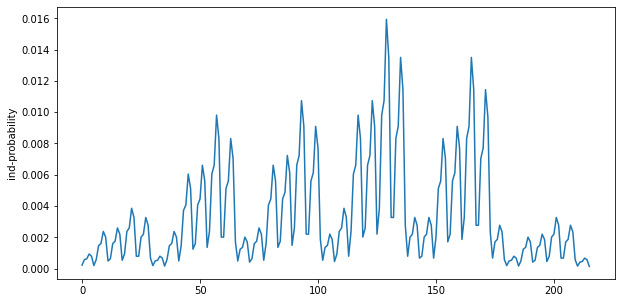

In [38]:
plt.subplots(figsize=(10,5))
sns.lineplot(data=df_ipatterns, x=df_ipatterns.index, y='ind-probability')
plt.show()

As expected, the probabilities are too weak to rely on. Moreover, their increments are minimal and always oscillate at low levels.

The last graph of interest will be its distribution.

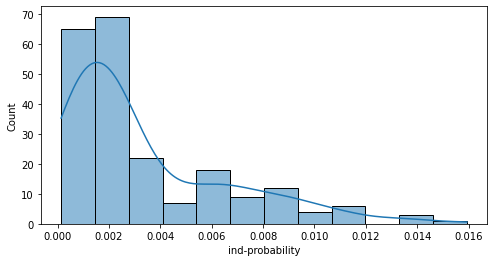

In [39]:
plt.subplots(figsize=(8,4))
sns.histplot(data=df_ipatterns, x='ind-probability', kde=True)
plt.show()

In [40]:
df_ipatterns.describe()

,ind-probability
count,216.000000
mean,0.003397
std,0.003230
min,0.000138
25%,0.000934
50%,0.002203
75%,0.005121
max,0.015937


Let us prove that the probability of intersection of events ignores the order of our pattern-chain.

In [41]:
df_ipatterns[(df_ipatterns['pattern']=='AAB') | (df_ipatterns['pattern']=='ABA') | (df_ipatterns['pattern']=='BAA')]

,pattern,ind-probability
1,AAB,0.000575
6,ABA,0.000575
36,BAA,0.000575


This is what we said at the beginning, and as we can see it was demonstrated. The probability of independent events is insufficient to conclude our study due to the nature of the market... although each price is independent of the previous one, we must take into account the order as an additional step.

**Conclusion**

Both the average and the distribution is irrelevant, and therefore we conclude the following; if we want to make a system based on these patterns we must analyze and think carefully all of the above. Understand that in the real world there are risks associated with the available capital of our account and the time frame in which we move (since it would not make sense to make a trading system on a long-term time scale if our account does not support such spreads ...), such patterns will be based on the last said, and will fail even more if the intervals that form them are excessively large making us believe that we are facing the discovery of the century when in fact they do not correctly represent the average price intervals of the market.

An expert system incapable of correctly classifying the order of the patterns it seeks to exploit is a system doomed to failure, if we continue with this idea we already know what results we may find in the future. Therefore we should never trust anyone who claims to have found the holy grail of market patterns, they would be liars, mathematics is our witness and great teacher in this search.

# Conditional probability and Bayes' theorem for dependent chains of events

In the previous section we talked about independent events and how to use probability and combinatorics to model such chains of events, we also demonstrated the danger of using such theory alone. In the following we will complete the missing mathematical notions and definitions in order to conclude our analysis on the efficiency of patterns in the market and how convenient they are to use in a theoretical trading system, let's start with the definition of conditional probability for dependent events followed by an explanation.

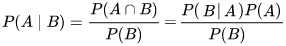

This is the simplest form of the rule for knowing the probability of two dependent events, which is read as "*the probability of A given B*". The following tree diagram explains this, we will continue with the explanation.

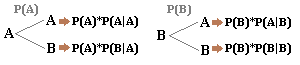

In other words, what we are looking for is an ordered sequence of events, so we can abstractly represent all the possible "chains" (dependent events) of probabilities. However this is not all, because in the markets there are not only two price patterns but thanks to this scheme we managed to simplify the base model, now we only need to generalize the concept of conditional probability.

**Bayes' Theorem**

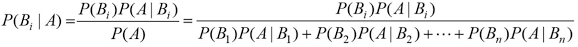

In summary:
```
Bayes' theorem allows to relate the conditional probabilities of an event A given an event B with the probability of B given A.
In this way the formula described above generalizes the events regardless of their number, the denominator is the total probability of the events we are looking for.
In other words, with this formula we can know the probability of the occurrence of a hypothesis 'A' given that we observe evidence 'B'.
This does not tell us the probability of the events themselves, but how likely it is that one will occur given that the first one was observed.
```
Now that we understand this there is one last notion that we must complement in order to model the market correctly, let's look at the Markovian property.

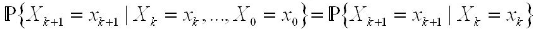

This property tells us that it is not necessary to know all the past (historical data) to explain the future, it is enough to have the current closing price of the market. This is relevant because in this way we can say that the events are independent in the sense that a price (or price interval) does not influence the formation of the next, so we will have a much simpler model as this implies that markets have no memory.

With this in mind we can now write the function that calculates the probability of a chain of patterns using Bayes' theorem and the law of total probability.

**Bayes function for chain of events: Conditional probability**

In [42]:
def conditional_prob(chain, probs_dict):
  p = 1
  for c in chain:
    p*= probs_dict[c]
  return p

probs_dict = {'A':0.5, 'B':0.5}
chain = ['A', 'B']
conditional_prob(chain, probs_dict)

0.25

As we can see this first function calculates the joint probabilities, the example deals with a simple chain composed by two possible events A and B with their associated probabilities (necessary to execute the calculations).

**Bayes function for chain of events: Law of total probability**

In [43]:
def total_prob_secs(sec, probs_dict):
  l = len(sec)
  last = sec[-1]
  secs = []
  for item in product(probs_dict.keys(), repeat=l):
    # agregamos el item solo si el final de la cadena tiene el evento correspondiente
    # por ejemplo si buscamos "A|B" solo las que terminen en B seran agregadas
    if item[-1] is last:
      secs.append(item)
  
  return secs

def total_prob(secs, probs_dict):
  total_prob = 0
  for s in secs:
    p = 1
    for i in s: p*= probs_dict[i]
    total_prob+= p

  return total_prob

probs_dict = {'A':0.5, 'B':0.5}
chain = ['A', 'B']
total_secs = total_prob_secs(chain, probs_dict)

print("total possible sequences/paths:{}".format(total_secs))
print("total probability:{}".format( total_prob(total_secs, probs_dict) ))

total possible sequences/paths:[('A', 'B'), ('B', 'B')]
total probability:0.5


This is the denominator of the formula, which corresponds to the total probability. We need to first obtain all possible sequences of paths given the sequence of events to calculate, finally we multiply and apply the summation(per iteration of each chain).

Putting all this together I will call the final function **Bayes**.

In [44]:
def Bayes(sec, probs_dict):
  def conditional_prob(sec, probs_dict):
    p = 1
    for s in sec:
      p*= probs_dict[s]
    return p

  def total_prob_secs(sec, probs_dict):
    l = len(sec)
    last = sec[-1]
    secs = []
    for item in product(probs_dict.keys(), repeat=l):
      if item[-1] is last:
        secs.append(item)
    
    return secs

  def total_prob(secs, probs_dict):
    total_prob = 0
    for s in secs:
      p = 1
      for i in s:
        p*= probs_dict[i]
      total_prob+= p

    return total_prob

  return conditional_prob(sec, probs_dict) / total_prob(total_prob_secs(sec, probs_dict), probs_dict)

print('Prob A|B:', Bayes(['A', 'B'], {'A':0.5, 'B':0.5, 'C':0.1}))
print('Prob A|B,C:', Bayes(['A', 'B', 'C'], {'A':0.5, 'B':0.5, 'C':0.1}))

Prob A|B: 0.45454545454545453
Prob A|B,C: 0.20661157024793386


*Note: The parameter passed to the function is read as 'A' given 'B', given 'C'. That is, it respects the order of the formula.

Using everything we have learned let's implement a class which we will call **DEChains**, at this point we will recycle some of the functions and classes already created. Remember that the generation of price ranges is mandatory, this is done by the class **PatternsEngine** which will calculate the probabilities of the patterns in chains of length 1 (as we saw in the section of *Chain generator class*), these will be used to form all possible sequences making use of combinatorics. At the same time each pattern will have implicitly an associated interval which is coded and can be obtained if desired, this is very important because if we want to create custom intervals for us (and not for the function itself) we must pass such parameters to the class.

Remember that **PatternsEngine** inherits the methods of the base class **PatternsChainsGenerator** which executes the calculations explained and tested in the section of *Encoding patterns*, that is; the interval or delta that composes each candle (each pattern) and the total ranges taken using a number of N deviations.

In [45]:
class DEChains():
  def __init__(self, df_candles):
    pse = PatternsEngine(df_candles)
    self.__patterns = pse.compute()
    self.__ep_dict = None

  def __encrypt_probs(self, patterns_dict):
    letters = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

    n_letters = len(letters)
    n_bodies= len(bodies)
    i = 0
    level = 1
    code = {}
    for p in patterns_dict.values():
      if i >= n_letters:
        i = 0
        level+= 1
      c = ''
      for _ in range(level): c+= letters[i]
      code[c] = p
      i+= 1
    return code

  def __bayes(self, sec, probs_dict):
    def conditional_prob(sec, probs_dict):
      p = 1
      for s in sec:
        p*= probs_dict[s]
      return p

    def total_prob_secs(sec, probs_dict):
      l = len(sec)
      last = sec[-1]
      secs = []
      for item in product(probs_dict.keys(), repeat=l):
        # agregamos el item solo si el final de la cadena tiene el evento correspondiente
        # por ejemplo si buscamos "A|B" solo las que terminen en B seran agregadas
        if item[-1] is last:
          secs.append(item)
      
      return secs

    def total_prob(secs, probs_dict):
      total_prob = 0
      for s in secs:
        p = 1
        for i in s:
          p*= probs_dict[i]
        total_prob+= p

      return total_prob

    return conditional_prob(sec, probs_dict) / total_prob(total_prob_secs(sec, probs_dict), probs_dict)

  def predict_chain(self, chain):
    self.__ep_dict = self.__encrypt_probs(self.__patterns)
    return self.__bayes(chain, self.__ep_dict)

  def predict_chains(self, chains_len):
    prob_dict = self.__encrypt_probs(self.__patterns)
    chains = [item for item in product(prob_dict, repeat=chains_len)]
    probs = []
    for c in chains:
      probs.append(self.__bayes(c, prob_dict))
    df = pd.DataFrame(data=chains)
    df["Probability"] = probs
    return df

  def total_posible_chains(self): return len([item for item in product(self.__ep_dict.keys(), repeat=chains_len)])

  def get_prob_matrix(self):
    return pd.DataFrame(data=self.__encrypt_probs(self.__patterns).items(), columns=['Pattern', 'Probability'])

As a first basic example we create the object of the class and calculate a single conditional probability string, the only parameter passed will represent an event of type A|B,C.

That is, probability of pattern A given that pattern B happened and given that pattern C happened first (respecting the order).

In [46]:
de_chains = DEChains(df_candles["Delta"])
de_chains.predict_chain(['A','B','C'])

0.011605115565991968

Let's make the calculation more complex, let's calculate all possible pattern chains with length=3.

In [47]:
df_chains = de_chains.predict_chains(3)
df_chains.head()

,0,1,2,Probability
0,A,A,A,0.004563
1,A,A,B,0.004563
2,A,A,C,0.004563
3,A,A,D,0.004563
4,A,A,E,0.004563


Let's plot the different possible probability chains along with their respective distributions, and we will repeat these complex calculations for chains with lengths of: 2, 3 and 4.

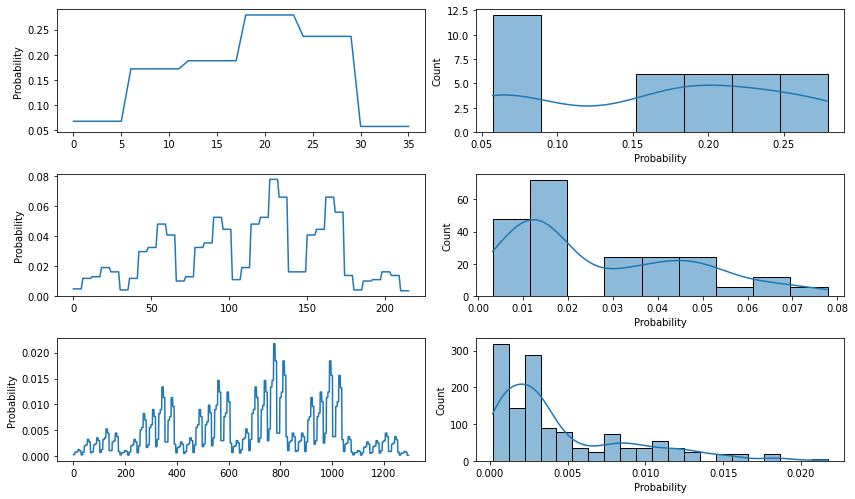

In [48]:
def plot_chains(df_chains):
  _, axs = plt.subplots(figsize=(12, 7), ncols=2, nrows=3)
  l = len(df_chains)
  for i in range(l):
    c = df_chains[i]
    sns.lineplot(data=c, x=c.index, y='Probability', ax=axs[i][0])
    sns.histplot(data=c['Probability'], kde=True,  ax=axs[i][1])
  plt.tight_layout()
  plt.show()

df_chains_ = []
for i in [2, 3, 4]:
  df_chains_.append(de_chains.predict_chains(i))

plot_chains(df_chains_)

As can be seen, as the chains grow in length their probabilities decrease drastically.

The following is the probability matrix of all the patterns classified in the market.

In [49]:
de_chains.get_prob_matrix()

,Pattern,Probability
0,A,0.060927
1,B,0.154967
2,C,0.169536
3,D,0.251656
4,E,0.213245
5,F,0.051656


**Conclusion**

As we see the probabilities go down more and more as our chain of events or patterns becomes larger, it was expected since stochastic statistics warn us of this; the larger (tends to +infinity) is a sequence of events, the probability that it repeats itself gets closer and closer to 0.

# Bayes Engine: Developing heuristics and statistical engine

This section will implement everything learned so far (mainly in the last two sections), in addition to the class we will optimize things that we left pending so far. On the other hand the fact that certain functions are discarded (not used in our final statistical engine) does not mean that they are not useful, they were only a support that at the time helped us to understand what we should.

We will also innovate new functions to be able to create custom pattern characteristics in addition to complement the study of probability for independent events. The final class will be called **BayesEngine**.

In [50]:
import scipy.stats as st
from itertools import product

class BayesEngine:
  def __init__(self, df_body):
    self.__df_body = df_body.values
    self.__mean= df_body.mean()
    self.__std = df_body.std()

  def __bayes(self, sec, probs_dict):
    def conditional_prob(sec, probs_dict):
      p = 1
      for s in sec:
        p*= probs_dict[s]
      return p

    def total_prob_secs(sec, probs_dict):
      l = len(sec)
      last = sec[-1]
      secs = []
      for item in product(probs_dict.keys(), repeat=l):
        # agregamos el item solo si el final de la cadena tiene el evento correspondiente
        # por ejemplo si buscamos "A|B" solo las que terminen en B seran agregadas
        if item[-1] is last:
          secs.append(item)
      
      return secs

    def total_prob(secs, probs_dict):
      total_prob = 0
      for s in secs:
        p = 1
        for i in s:
          p*= probs_dict[i]
        total_prob+= p

      return total_prob

    tp = total_prob(total_prob_secs(sec, probs_dict), probs_dict)
    if tp == 0:
      return np.inf
    return conditional_prob(sec, probs_dict) / tp

  def __generate_candles_body_range(self, interval_percent, n_std):
    # standarization
    # z = (x - mean)/ std_dev
    def standarization(z_score, mean, std_dev):
      return z_score*std_dev + mean

    mean      = self.__mean
    std_dev   = self.__std
    z_score   = st.norm.ppf(0.5 + (interval_percent/2))
    x_step    = standarization(z_score, mean, std_dev)
    pos_ranges_x = []
    x = 0
    while x < std_dev*n_std:
      pos_ranges_x.append( x )
      x+= x_step
    
    neg_ranges_x = []
    n_intervals = len(pos_ranges_x)
    for i in range(n_intervals - 1, 0, -1):
      neg_ranges_x.append(-pos_ranges_x[i])
    
    return neg_ranges_x + pos_ranges_x, x_step

  def __encrypt(self, values):
    letters = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

    n_letters = len(letters)
    i = idx= 0
    level = 1
    code = {}
    for v in values:
      if i >= n_letters:
        i = 0
        level+= 1
      c = ''
      for _ in range(level):
        c+= letters[i]
      code[c] = v
      i+= 1

    return code
  
  def __filter_bad_intervals(self, encripted_bodies_dict, intervals):
    intervals_ = []
    for i in intervals:
      # desencriptamos
      min_ = encripted_bodies_dict[i[0]]
      max_ = encripted_bodies_dict[i[1]]
      if min_ >= 0:
        if min_ >= max_:
          continue
      else:
        if max_ <= min_:
          continue
      
      intervals_.append(i)
    return intervals_

  def __decrypt(self, body_ranges_dict, intervals):
    decrypted_chain = []
    for i in intervals:
      decrypted_chain.append((body_ranges_dict[i[0]], body_ranges_dict[i[1]]))
    return decrypted_chain

  def __filter_excessive_intervals(self, intervals, max_dist):
    valid_patterns_probs = []
    for p in intervals:
      if np.abs(p[0] - p[1]) <= max_dist:
        valid_patterns_probs.append(p)
    return valid_patterns_probs
  
  def __joint_prob(self, chain, probs_dict):
    j = 1
    for c in chain:
      j*= probs_dict[c]
    return j

  def generate_patterns_intervals(self, interval_percent, n_std, filter_excess=True):
    body_ranges, x_range_step = self.__generate_candles_body_range(interval_percent, n_std)
    body_ranges_dict = self.__encrypt(body_ranges)

    _minmax_intervals = [item for item in product(body_ranges_dict.keys(), repeat=2)]
    body_intervals = self.__filter_bad_intervals(body_ranges_dict, _minmax_intervals)

    intervals = self.__decrypt(body_ranges_dict, body_intervals)
    if filter_excess is True:
      return self.__filter_excessive_intervals(intervals, x_range_step)
    else:
      return intervals

  def predict_pattern(self, interval):
    def is_bound(value, interval):
      return (value >= interval[0] and value <= interval[1])
    def laplace_rule(matches, observations):
      return matches/len(observations)

    matches = 0
    for b in self.__df_body:
      if is_bound(b, interval):
        matches+= 1
    return laplace_rule(matches, self.__df_body)

  def predict_patterns(self, interval_percent, n_std, filter_excess=True):
    patterns_intervals = self.generate_patterns_intervals(interval_percent, n_std, filter_excess)
    intervals_dict = {}
    for p in patterns_intervals:
      intervals_dict[p] = self.predict_pattern(p)
      
    return intervals_dict

  def get_predicted_patterns(self, interval_percent, n_std, filter_excess=True):
    # predecimos individualmente cada patron de precio generado
    patterns_dict = self.predict_patterns(interval_percent, n_std, filter_excess)
    # formamos un diccionario con las probabilidades calculadas codificadas en letras
    patterns_probs_dict = self.__encrypt(patterns_dict.values())
    return patterns_probs_dict
  
  def generate_chains(self, chain_len, interval_percent, n_std, filter_excess=True):
    patterns_probs_dict = self.get_predicted_patterns(interval_percent, n_std, filter_excess)
    chains = [item for item in product(patterns_probs_dict.keys(), repeat=chain_len)]
    return chains, patterns_probs_dict

  def predict_chains(self, chain_len, interval_percent, n_std, filter_excess=True):
    chains, patterns_probs_dict = self.generate_chains(chain_len, interval_percent, n_std, filter_excess)
    probs = []
    patterns = []
    ind_probs = []
    for c in chains:
      chain = ''
      for i in range(chain_len):
        chain+= str(c[i])
      patterns.append(chain)
      probs.append(self.__bayes(c, patterns_probs_dict))
      ind_probs.append(self.__joint_prob(c, patterns_probs_dict))
    return pd.DataFrame(data={'Pattern':patterns, 'Bayes-prob':probs, "Ind-prob":ind_probs})

  def predict_chain(self, chain, interval_percent, n_std, filter_excess=True):
    patterns_probs_dict = self.get_predicted_patterns(interval_percent, n_std, filter_excess)
    return self.__bayes(chain, patterns_probs_dict), self.__joint_prob(chain, patterns_probs_dict)

  def predict_custom_chain(self, delta_intervals_chain):
    #def standarization(interval_percent):
      #x = st.norm.ppf(0.5 + interval_percent)*self.__std + self.__mean
      #return x
    probs = []
    #intervals = []
    for c in delta_intervals_chain:
      #interval = (standarization(c[0]), standarization(c[1]))
      #intervals.append(interval)
      pattern_prob = self.predict_pattern(c)
      #if pattern_prob == 0:
        #return None, None, None
      probs.append(pattern_prob)
    # codificamos las probabilidades en un diccionario(i.e Char:Probability)
    probs_dict = self.__encrypt(probs)
    pattern = [p for p in probs_dict.keys()]

    return self.__bayes(pattern, probs_dict), self.__joint_prob(pattern, probs_dict), probs_dict#, intervals

Once the class has been compiled, we create the object

In [51]:
be = BayesEngine(df_candles["Delta"])

Let's generate a set of patterns using a 40% acceptance interval, as we know the candlestick body sizes or patterns will increase N times but the increments or distances (between the intervals) will always remain constant. N represents the number of standard deviations taken to generate these ranges, in this example we will take 3.5.

In [52]:
interval = 0.4
n_std = 3.5
be.generate_patterns_intervals(interval, n_std)

[(-144.75851440581297, -120.63209533817748),
 (-120.63209533817748, -96.50567627054198),
 (-96.50567627054198, -72.37925720290649),
 (-72.37925720290649, -48.25283813527099),
 (-48.25283813527099, -24.126419067635496),
 (-24.126419067635496, 0),
 (0, 24.126419067635496),
 (24.126419067635496, 48.25283813527099),
 (48.25283813527099, 72.37925720290649),
 (72.37925720290649, 96.50567627054198),
 (96.50567627054198, 120.63209533817748),
 (120.63209533817748, 144.75851440581297)]

Using the intervals generated above (which represent our patterns) let's see what is the probability of occurrence is in the S&P500. Recall that this can be taken to any market.

In [53]:
be.predict_patterns(interval, n_std)

{(-144.75851440581297, -120.63209533817748): 0.007947019867549669,
 (-120.63209533817748, -96.50567627054198): 0.010596026490066225,
 (-96.50567627054198, -72.37925720290649): 0.03708609271523179,
 (-72.37925720290649, -48.25283813527099): 0.060927152317880796,
 (-48.25283813527099, -24.126419067635496): 0.15496688741721854,
 (-24.126419067635496, 0): 0.1695364238410596,
 (0, 24.126419067635496): 0.25165562913907286,
 (24.126419067635496, 48.25283813527099): 0.21324503311258278,
 (48.25283813527099, 72.37925720290649): 0.051655629139072845,
 (72.37925720290649, 96.50567627054198): 0.01456953642384106,
 (96.50567627054198, 120.63209533817748): 0.010596026490066225,
 (120.63209533817748, 144.75851440581297): 0.0026490066225165563}

Now let's calculate all the possible combinations of patterns that can be formed with a length=3 (this is what we conceptually call chains). In addition to this let's look at the individual probability of each pattern that makes up the strings (this should not be confused with the probability of the string itself), the dictionary stores its value encoded in the letters used.

In [98]:
chains, patterns_probs_dict= be.generate_chains(3, interval, n_std)
print("Patterns-chains:{}".format(chains[:50]))
print("Patterns-probas-dict:{}".format(patterns_probs_dict))

Patterns-chains:[('A', 'A', 'A'), ('A', 'A', 'B'), ('A', 'A', 'C'), ('A', 'A', 'D'), ('A', 'A', 'E'), ('A', 'A', 'F'), ('A', 'A', 'G'), ('A', 'A', 'H'), ('A', 'A', 'I'), ('A', 'A', 'J'), ('A', 'A', 'K'), ('A', 'A', 'L'), ('A', 'B', 'A'), ('A', 'B', 'B'), ('A', 'B', 'C'), ('A', 'B', 'D'), ('A', 'B', 'E'), ('A', 'B', 'F'), ('A', 'B', 'G'), ('A', 'B', 'H'), ('A', 'B', 'I'), ('A', 'B', 'J'), ('A', 'B', 'K'), ('A', 'B', 'L'), ('A', 'C', 'A'), ('A', 'C', 'B'), ('A', 'C', 'C'), ('A', 'C', 'D'), ('A', 'C', 'E'), ('A', 'C', 'F'), ('A', 'C', 'G'), ('A', 'C', 'H'), ('A', 'C', 'I'), ('A', 'C', 'J'), ('A', 'C', 'K'), ('A', 'C', 'L'), ('A', 'D', 'A'), ('A', 'D', 'B'), ('A', 'D', 'C'), ('A', 'D', 'D'), ('A', 'D', 'E'), ('A', 'D', 'F'), ('A', 'D', 'G'), ('A', 'D', 'H'), ('A', 'D', 'I'), ('A', 'D', 'J'), ('A', 'D', 'K'), ('A', 'D', 'L'), ('A', 'E', 'A'), ('A', 'E', 'B')]
Patterns-probas-dict:{'A': 0.007947019867549669, 'B': 0.010596026490066225, 'C': 0.03708609271523179, 'D': 0.060927152317880796, 'E':

If we only want the list of individual patterns analyzed in the market (and coded).

In [55]:
be.get_predicted_patterns(interval, n_std)

{'A': 0.007947019867549669,
 'B': 0.010596026490066225,
 'C': 0.03708609271523179,
 'D': 0.060927152317880796,
 'E': 0.15496688741721854,
 'F': 0.1695364238410596,
 'G': 0.25165562913907286,
 'H': 0.21324503311258278,
 'I': 0.051655629139072845,
 'J': 0.01456953642384106,
 'K': 0.010596026490066225,
 'L': 0.0026490066225165563}

Calculation of the probability of a single chain of patterns; recall that two probabilities are calculated: the Bayesian probability (the chain should be read as A|B,C) and the joint probability (the chain should be read as A&B&C) which is the intersection of events.

In [56]:
bayes_prob, chain_prob = be.predict_chain(['A','B','C'], interval, n_std)
print("Conditional-probability:",bayes_prob)
print("Chain/Joint-probability:",chain_prob)

Conditional-probability: 8.671522719389527e-05
Chain/Joint-probability: 3.1229024171415748e-06


Let's calculate the probability of a pattern chain given custom intervals.

Recall that these numbers represent the accepted candlestick body sizes based on the price distribution of the S&P500 index so these values are fixed for this market, if you want to apply this same pattern chain to other markets you should do the corresponding statistical analysis on their probability distribution to choose appropriate values (or use the **predict_chains** function with percentage intervals).

In [57]:
bayes_prob, joint_prob, prob_dict = be.predict_custom_chain([(0,40), (40,60), (60,80)])
print("Probability A|B:",bayes_prob)
print("Joint Probability:",joint_prob)
print("Probability-dict:",prob_dict)

Probability A|B: 0.12393526678416918
Joint Probability: 0.0007638307951521819
Probability-dict: {'A': 0.4198675496688742, 'B': 0.08079470198675497, 'C': 0.022516556291390728}


At this point there is something I must repeat; the pattern chains along with their probability were calculated using *conditional probability* and *Bayes' theorem*. Therefore a high probability does NOT mean that the pattern is reliable, but simply that put in such order it is more likely to happen than in another (for example a pattern can have high probability given the order A|B,C while seen in B|C,A the probability can be very low), this can help us to know if there is any preference or causality of such events in the market.
In addition to this we obtain the *joint probability* which is the intersection of the events, as explained before this is the probability for independent events regardless of the order (in the examples, you can see that the probability of finding any set of patterns in a chain is practically zero).

Continuing with the example we will calculate all possible chains with length=3.

In [58]:
be.predict_chains(3, interval, n_std)

,Pattern,Bayes-prob,Ind-prob
0,AAA,0.000065,5.018950e-07
1,AAB,0.000065,6.691934e-07
2,AAC,0.000065,2.342177e-06
3,AAD,0.000065,3.847862e-06
4,AAE,0.000065,9.786953e-06
...,...,...,...
1723,LLH,0.000007,1.496391e-06
1724,LLI,0.000007,3.624797e-07
1725,LLJ,0.000007,1.022379e-07
1726,LLK,0.000007,7.435482e-08


Let's plot the probability distributions

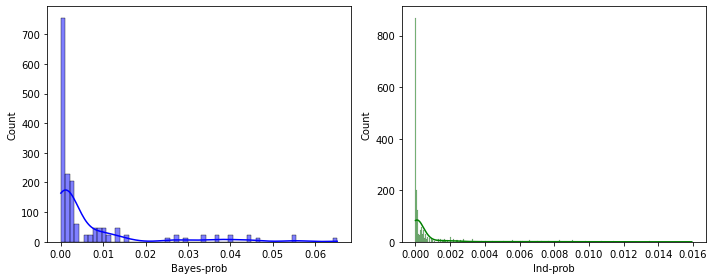

In [59]:
fig, axs = plt.subplots(figsize=(10, 4), ncols=2)
tmp = be.predict_chains(3, interval, n_std)
sns.histplot(data=tmp["Bayes-prob"], kde=True, ax=axs[0], color='blue')
sns.histplot(data=tmp["Ind-prob"], kde=True, ax=axs[1], color='green')
plt.tight_layout()
plt.show()

As we have been saying as the chains grow in length their probability decreases drastically, even if we keep chains of two patterns the probability continues to be a rarity... when we ran the same analysis looking at each pattern (and its characteristics) separately we also saw this, therefore it is to be expected that even the most "famous" market patterns appear casually (and not in the same way in all markets), more of this in the last section.

# Analysis of classic patterns and candlesticks on the S&P500. Final part

It is time to use our Bayesian engine to test the most common patterns found in any material on the internet and books. These proliferate everywhere and warn us how important they are in the "price action", as such many say that learning them will be enough guarantee to have a good reading of what the market will do and therefore be able to make reliable predictions creating the illusion of becoming true masters of price reading. The big flaw with this premise is that we know in advance that the patterns have unique characteristics in each market (in addition to the time scales), if we ignore this and accept the most common visual analysis we will be doomed to fail, thanks to the statistical studies conducted throughout this article, empirically demonstrate this and how such sequences when they grow tend to have virtually zero and negligible probabilities, which makes them rarities in the markets... making use of brute force and looking for all combinations to best maximize the best probability chains are still far below what is considered reliable to be credible, and therefore used (even more so to design a trading system based on this).

Next we will recap what we saw in the first phase and analyze more temporal market data, I will also show some classic candlestick pattern images and use them (as estimated) in our Bayesian statistical engine to see what it has to tell us about them. 

*Let's load the data from the beginning of 2015 to the beginning of 2021.*

In [60]:
ticker_sp500 = yf.Ticker('^GSPC')
df_data = ticker_sp500.history(period='1d', start='2015-1-1', end='2021-1-1')
df_data.drop(["Volume", "Dividends", "Stock Splits"], axis=1, inplace=True)
df_data.head()

,Open,High,Low,Close
Date,,,,
2015-01-02,2058.899902,2072.360107,2046.040039,2058.199951
2015-01-05,2054.439941,2054.439941,2017.339966,2020.579956
2015-01-06,2022.150024,2030.250000,1992.439941,2002.609985
2015-01-07,2005.550049,2029.609985,2005.550049,2025.900024
2015-01-08,2030.609985,2064.080078,2030.609985,2062.139893


Candlestick body generator function; these will be used by our statistical engine to calculate the probabilities of the pattern chains in the market.

In [61]:
def generate_deltas_from_prices(df):
  def get_candle_type(price):
    if price["Close"] > price["Open"] : return "bullish"
    if price["Close"] < price["Open"] : return "bearish"
    #if price["Close"] == price["Open"] : return "undefined"
    return "undefined"

  def set_candle_type(row):
    type_ = row["Type"]
    if type_ is "bullish":
      return row["Delta"]
    if type_ is "bearish":
      return -row["Delta"]

    return None

  df_candles = pd.DataFrame()
  df_candles["Delta"] = df["High"] - df["Low"]
  df_candles["Type"]  = df.apply(lambda row: get_candle_type(row), axis=1)
  df_candles["Delta"] = df_candles.apply(lambda row: set_candle_type(row), axis=1)
  df_candles.dropna(axis=1)
  return df_candles

df_candles = generate_deltas_from_prices(df_data)
df_candles.head()

,Delta,Type
Date,,
2015-01-02,-26.320068,bearish
2015-01-05,-37.099976,bearish
2015-01-06,-37.810059,bearish
2015-01-07,24.059937,bullish
2015-01-08,33.470093,bullish


Price delta plot, on time scale

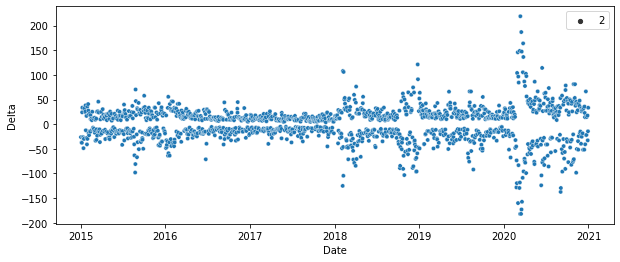

In [62]:
plt.subplots(figsize=(10,4))
sns.scatterplot(data=df_candles, x=df_candles.index, y='Delta', size=2)
plt.show()

Probability distribution

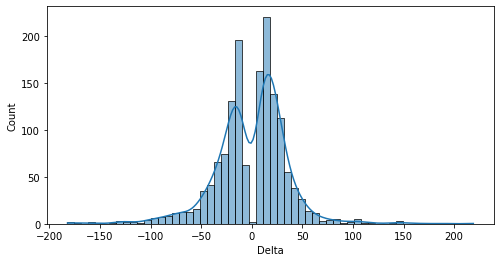

In [63]:
plt.subplots(figsize=(8,4))
sns.histplot(data=df_candles["Delta"], kde=True)
plt.show()

Boxplot + Swarmplot to have a better visual aid, we look for where the largest number of price bodies accumulate.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 23.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


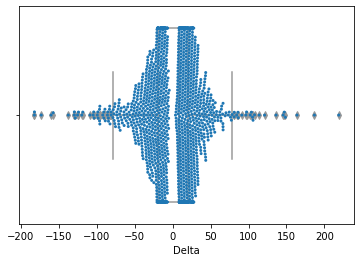

In [64]:
sns.boxplot(data=df_candles, x='Delta', color='white')
sns.swarmplot(data=df_candles, x='Delta', size=3)
plt.show()

As you can see there are no candlestick patterns or prices around 0, this makes sense because there could not exist null candlestick bodies, remember that we take the body as a difference between the High and Low.

Now we can create the object of the class **BayesEngine**, this will be used to study the most "classic" market patterns.

In [65]:
bayes = BayesEngine(df_candles["Delta"])

**Patron 1.**: **Harami**

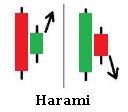

**Bearish Harami.**

In [66]:
bayes_prob, joint_prob, patterns_dict= bayes.predict_custom_chain([(-40, -20), (10, 20)])
print("Chain probability:",joint_prob)
print("Conditional probability:",bayes_prob)
print("Patterns probability:", patterns_dict)

Chain probability: 0.029341414668780146
Conditional probability: 0.39697542533081287
Patterns probability: {'A': 0.13898080741230973, 'B': 0.21111846459298478}


Bearish Harami[big intervals]

In [67]:
bayes_prob, joint_prob, patterns_dict= bayes.predict_custom_chain([(-60, -40), (20, 30)])
print("Chain probability:",joint_prob)
print("Conditional probability:",bayes_prob)
print("Patterns probability:", patterns_dict)

Chain probability: 0.006764424662556212
Conditional probability: 0.2826086956521739
Patterns probability: {'A': 0.05162144275314361, 'B': 0.13103904698874919}


Bearish Harami[+big intervals]

In [68]:
bayes_prob, joint_prob, patterns_dict= bayes.predict_custom_chain([(-80, -65), (30, 40)])
print("Chain probability:",joint_prob)
print("Conditional probability:",bayes_prob)
print("Patterns probability:", patterns_dict)

Chain probability: 0.0008978937165397716
Conditional probability: 0.2336448598130841
Patterns probability: {'A': 0.01654533421575116, 'B': 0.054268696227663796}


**Bullish Harami.**

In [69]:
bayes_prob, joint_prob, patterns_dict= bayes.predict_custom_chain([(10, 20), (-40, -20)])
print("Chain probability:",joint_prob)
print("Conditional probability:",bayes_prob)
print("Patterns probability:", patterns_dict)

Chain probability: 0.029341414668780146
Conditional probability: 0.6030245746691871
Patterns probability: {'A': 0.21111846459298478, 'B': 0.13898080741230973}


Bullish Harami[big intervals]

In [70]:
bayes_prob, joint_prob, patterns_dict= bayes.predict_custom_chain([(20, 30), (-60, -40)])
print("Chain probability:",joint_prob)
print("Conditional probability:",bayes_prob)
print("Patterns probability:", patterns_dict)

Chain probability: 0.006764424662556212
Conditional probability: 0.7173913043478262
Patterns probability: {'A': 0.13103904698874919, 'B': 0.05162144275314361}


Bullish Harami[+big intervals]

In [71]:
bayes_prob, joint_prob, patterns_dict= bayes.predict_custom_chain([(30, 40), (-80, -65)])
print("Chain probability:",joint_prob)
print("Conditional probability:",bayes_prob)
print("Patterns probability:", patterns_dict)

Chain probability: 0.0008978937165397716
Conditional probability: 0.7663551401869159
Patterns probability: {'A': 0.054268696227663796, 'B': 0.01654533421575116}


**Patron 2.: Hammer**

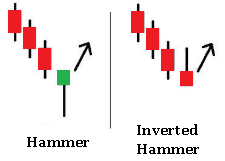

**Bullish Hammer**

In [72]:
bayes_prob, joint_prob, patterns_dict= bayes.predict_custom_chain([(-25, -15), (-25, -15), (-25, -15), (25, 35)])
print("Chain probability:",joint_prob)
print("Conditional probability:",bayes_prob)
print("Patterns probability:", patterns_dict)

Chain probability: 0.00017463579029711873
Conditional probability: 0.017803928014609338
Patterns probability: {'A': 0.12045003309066843, 'B': 0.12045003309066843, 'C': 0.12045003309066843, 'D': 0.099933818663137}


Bullish Hammer[big intervals]

In [73]:
bayes_prob, joint_prob, patterns_dict= bayes.predict_custom_chain([(-35, -25), (-35, -25), (-35, -25), (35, 45)])
print("Chain probability:",joint_prob)
print("Conditional probability:",bayes_prob)
print("Patterns probability:", patterns_dict)

Chain probability: 1.3252192384898398e-05
Conditional probability: 0.022405470127043168
Patterns probability: {'A': 0.07015221707478492, 'B': 0.07015221707478492, 'C': 0.07015221707478492, 'D': 0.03838517538054269}


Bullish Hammer[+big intervals]

In [74]:
bayes_prob, joint_prob, patterns_dict= bayes.predict_custom_chain([(-45, -35), (-45, -35), (-45, -35), (40, 50)])
print("Chain probability:",joint_prob)
print("Conditional probability:",bayes_prob)
print("Patterns probability:", patterns_dict)

Chain probability: 2.177216675768783e-06
Conditional probability: 0.017944102524899124
Patterns probability: {'A': 0.04037061548643282, 'B': 0.04037061548643282, 'C': 0.04037061548643282, 'D': 0.03309066843150232}


**Bullish Inverted Hammer**

In [75]:
bayes_prob, joint_prob, patterns_dict= bayes.predict_custom_chain([(-25, -15), (-25, -15), (-25, -15), (-40, -35)])
print("Chain probability:",joint_prob)
print("Conditional probability:",bayes_prob)
print("Patterns probability:", patterns_dict)

Chain probability: 3.8165437614602106e-05
Conditional probability: 0.031058356651824607
Patterns probability: {'A': 0.12045003309066843, 'B': 0.12045003309066843, 'C': 0.12045003309066843, 'D': 0.02183984116479153}


Bullish Inverted Hammer[big intervals]

In [76]:
bayes_prob, joint_prob, patterns_dict= bayes.predict_custom_chain([(-35, -25), (-35, -25), (-35, -25), (-50, -40)])
print("Chain probability:",joint_prob)
print("Conditional probability:",bayes_prob)
print("Patterns probability:", patterns_dict)

Chain probability: 1.188127593128822e-05
Conditional probability: 0.02351323712317139
Patterns probability: {'A': 0.07015221707478492, 'B': 0.07015221707478492, 'C': 0.07015221707478492, 'D': 0.03441429516876241}


Bullish Inverted Hammer[+big intervals]

In [77]:
bayes_prob, joint_prob, patterns_dict= bayes.predict_custom_chain([(-45, -35), (-45, -35), (-45, -35), (-60, -50)])
print("Chain probability:",joint_prob)
print("Conditional probability:",bayes_prob)
print("Patterns probability:", patterns_dict)

Chain probability: 1.1321526713997672e-06
Conditional probability: 0.024862834935623416
Patterns probability: {'A': 0.04037061548643282, 'B': 0.04037061548643282, 'C': 0.04037061548643282, 'D': 0.017207147584381206}


**Patron 3.: Shooting Start & Hanging Man**

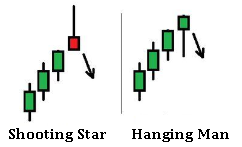

**Shooting Star**

In [78]:
bayes_prob, joint_prob, patterns_dict= bayes.predict_custom_chain([(15, 20), (15, 20), (15, 20), (-30, -25)])
print("Chain probability:",joint_prob)
print("Conditional probability:",bayes_prob)
print("Patterns probability:", patterns_dict)

Chain probability: 1.927752330323179e-05
Conditional probability: 0.024586359762573114
Patterns probability: {'A': 0.0814030443414957, 'B': 0.0814030443414957, 'C': 0.0814030443414957, 'D': 0.0357379219060225}


Shooting Star[big intervals]

In [79]:
bayes_prob, joint_prob, patterns_dict= bayes.predict_custom_chain([(25, 30), (25, 30), (25, 30), (-40, -35)])
print("Chain probability:",joint_prob)
print("Conditional probability:",bayes_prob)
print("Patterns probability:", patterns_dict)

Chain probability: 5.777916819389241e-06
Conditional probability: 0.026833676033651898
Patterns probability: {'A': 0.0641958967571145, 'B': 0.0641958967571145, 'C': 0.0641958967571145, 'D': 0.02183984116479153}


Shooting Star[+big intervals]

In [80]:
bayes_prob, joint_prob, patterns_dict= bayes.predict_custom_chain([(35, 40), (35, 40), (35, 40), (-50, -45)])
print("Chain probability:",joint_prob)
print("Conditional probability:",bayes_prob)
print("Patterns probability:", patterns_dict)

Chain probability: 1.0107121311435158e-07
Conditional probability: 0.01742620535487476
Patterns probability: {'A': 0.018530774321641297, 'B': 0.018530774321641297, 'C': 0.018530774321641297, 'D': 0.01588352084712111}


**Hanging Man**

In [81]:
bayes_prob, joint_prob, patterns_dict= bayes.predict_custom_chain([(15, 20), (15, 20), (15, 20), (25, 30)])
print("Chain probability:",joint_prob)
print("Conditional probability:",bayes_prob)
print("Patterns probability:", patterns_dict)

Chain probability: 3.462814371136081e-05
Conditional probability: 0.01838897761993377
Patterns probability: {'A': 0.0814030443414957, 'B': 0.0814030443414957, 'C': 0.0814030443414957, 'D': 0.0641958967571145}


Hanging Man[big intervals]

In [82]:
bayes_prob, joint_prob, patterns_dict= bayes.predict_custom_chain([(25, 30), (25, 30), (25, 30), (35, 40)])
print("Chain probability:",joint_prob)
print("Conditional probability:",bayes_prob)
print("Patterns probability:", patterns_dict)

Chain probability: 4.9024748770575376e-06
Conditional probability: 0.028115327946338378
Patterns probability: {'A': 0.0641958967571145, 'B': 0.0641958967571145, 'C': 0.0641958967571145, 'D': 0.018530774321641297}


Hanging Man[+big intervals]

In [83]:
bayes_prob, joint_prob, patterns_dict= bayes.predict_custom_chain([(35, 40), (35, 40), (35, 40), (45, 50)])
print("Chain probability:",joint_prob)
print("Conditional probability:",bayes_prob)
print("Patterns probability:", patterns_dict)

Chain probability: 8.422601092862632e-08
Conditional probability: 0.01951524806554393
Patterns probability: {'A': 0.018530774321641297, 'B': 0.018530774321641297, 'C': 0.018530774321641297, 'D': 0.013236267372600927}


**Patron 4.: Engulfing**

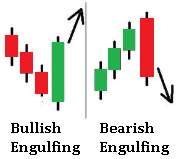

**Bullish Engulfing**

In [84]:
bayes_prob, joint_prob, patterns_dict= bayes.predict_custom_chain([(-15, 0), (-15, 0), (0, 40)])
print("Chain probability:",joint_prob)
print("Conditional probability:",bayes_prob)
print("Patterns probability:", patterns_dict)

Chain probability: 0.010580027859045786
Conditional probability: 0.03937851614007792
Patterns probability: {'A': 0.15155526141628062, 'B': 0.15155526141628062, 'C': 0.46062210456651226}


Bullish Engulfing[big intervals]

In [85]:
bayes_prob, joint_prob, patterns_dict= bayes.predict_custom_chain([(-30, -15), (-30, -15), (0, 40)])
print("Chain probability:",joint_prob)
print("Conditional probability:",bayes_prob)
print("Patterns probability:", patterns_dict)

Chain probability: 0.011236727591720487
Conditional probability: 0.04082613998874086
Patterns probability: {'A': 0.15618795499669094, 'B': 0.15618795499669094, 'C': 0.46062210456651226}


Bullish Engulfing[+big intervals]

In [86]:
bayes_prob, joint_prob, patterns_dict= bayes.predict_custom_chain([(-40, -20), (-40, -20), (40, 80)])
print("Chain probability:",joint_prob)
print("Conditional probability:",bayes_prob)
print("Patterns probability:", patterns_dict)

Chain probability: 0.0011888529643248908
Conditional probability: 0.1675729284224206
Patterns probability: {'A': 0.13898080741230973, 'B': 0.13898080741230973, 'C': 0.06154864328259431}


**Bearish Engulfing**

In [87]:
bayes_prob, joint_prob, patterns_dict= bayes.predict_custom_chain([(0, 15), (0, 15), (0, 40)])
print("Chain probability:",joint_prob)
print("Conditional probability:",bayes_prob)
print("Patterns probability:", patterns_dict)

Chain probability: 0.017320127603806593
Conditional probability: 0.052234710293247916
Patterns probability: {'A': 0.19391131700860356, 'B': 0.19391131700860356, 'C': 0.46062210456651226}


Bullish Engulfing[big intervals]

In [88]:
bayes_prob, joint_prob, patterns_dict= bayes.predict_custom_chain([(15, 30), (15, 30), (10, 40)])
print("Chain probability:",joint_prob)
print("Conditional probability:",bayes_prob)
print("Patterns probability:", patterns_dict)

Chain probability: 0.01789136575717544
Conditional probability: 0.0669062211662893
Patterns probability: {'A': 0.21244209133024486, 'B': 0.21244209133024486, 'C': 0.39642620780939775}


Bullish Engulfing[+big intervals]

In [89]:
bayes_prob, joint_prob, patterns_dict= bayes.predict_custom_chain([(20, 40), (20, 40), (40, 80)])
print("Chain probability:",joint_prob)
print("Conditional probability:",bayes_prob)
print("Patterns probability:", patterns_dict)

Chain probability: 0.0021135163810220283
Conditional probability: 0.18386103482806418
Patterns probability: {'A': 0.18530774321641297, 'B': 0.18530774321641297, 'C': 0.06154864328259431}


**Patron 5.: Three white soldiers**

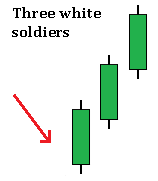

In [90]:
bayes_prob, joint_prob, patterns_dict= bayes.predict_custom_chain([(15, 30), (15, 30), (15, 30)])
print("Chain probability:",joint_prob)
print("Conditional probability:",bayes_prob)
print("Patterns probability:", patterns_dict)

Chain probability: 0.009587860447501362
Conditional probability: 0.11111111111111113
Patterns probability: {'A': 0.21244209133024486, 'B': 0.21244209133024486, 'C': 0.21244209133024486}


Three white soldiers[big intervals]

In [91]:
bayes_prob, joint_prob, patterns_dict= bayes.predict_custom_chain([(40, 60), (40, 60), (40, 60)])
print("Chain probability:",joint_prob)
print("Conditional probability:",bayes_prob)
print("Patterns probability:", patterns_dict)

Chain probability: 0.00012228984573783025
Conditional probability: 0.1111111111111111
Patterns probability: {'A': 0.04963600264725347, 'B': 0.04963600264725347, 'C': 0.04963600264725347}


Three white soldiers[+big intervals]

In [92]:
bayes_prob, joint_prob, patterns_dict= bayes.predict_custom_chain([(50, 70), (50, 80), (50, 80)])
print("Chain probability:",joint_prob)
print("Conditional probability:",bayes_prob)
print("Patterns probability:", patterns_dict)

Chain probability: 1.9831028661243694e-05
Conditional probability: 0.10516227113490646
Patterns probability: {'A': 0.024487094639311716, 'B': 0.028457974851091992, 'C': 0.028457974851091992}


**Patron 6.: Three black crows**

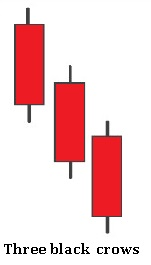

In [93]:
bayes_prob, joint_prob, patterns_dict= bayes.predict_custom_chain([(15, 30), (15, 30), (15, 30)])
print("Chain probability:",joint_prob)
print("Conditional probability:",bayes_prob)
print("Patterns probability:", patterns_dict)

Chain probability: 0.009587860447501362
Conditional probability: 0.11111111111111113
Patterns probability: {'A': 0.21244209133024486, 'B': 0.21244209133024486, 'C': 0.21244209133024486}


Three black crows[big intervals]

In [94]:
bayes_prob, joint_prob, patterns_dict= bayes.predict_custom_chain([(30, 45), (30, 45), (30, 45)])
print("Chain probability:",joint_prob)
print("Conditional probability:",bayes_prob)
print("Patterns probability:", patterns_dict)

Chain probability: 0.000407249608042094
Conditional probability: 0.11111111111111113
Patterns probability: {'A': 0.07412309728656519, 'B': 0.07412309728656519, 'C': 0.07412309728656519}


Three black crows[+big intervals]

In [95]:
bayes_prob, joint_prob, patterns_dict= bayes.predict_custom_chain([(50, 80), (50, 80), (50, 80)])
print("Chain probability:",joint_prob)
print("Conditional probability:",bayes_prob)
print("Patterns probability:", patterns_dict)

Chain probability: 2.3046871146850778e-05
Conditional probability: 0.11111111111111112
Patterns probability: {'A': 0.028457974851091992, 'B': 0.028457974851091992, 'C': 0.028457974851091992}


# Final conclusion

Throughout our market research we discovered tools and methods to help us answer what we were looking for, and after all the question in my opinion no longer stands; is it profitable to trade the market following patterns?, clearly the answer is a resounding no. Statistically speaking there is enough evidence to disprove this, probabilities decrease as we look for more ambitious candlesticks and therefore using them to make a trading system is doomed to failure.
There will always be gurus saying they found the key to the 'price action', what really happens is that certain patterns occur because they have an apparent frequency, not because they must appear necessarily...  anyone can replicate this same study in longer periods of time and even in different time-frames and market (such as FOREX), even so nothing guarantees that we find patterns that we can exploit at least not in the long term and much less in the case of large price chains, the stochastic nature of the market showed us, and the laws of probability are clear: as we prolong a sequence in time the occurrence of the same in the future is considerably low (mathematically tends to 0).

All is not lost because there are different methods to filter the (gaussian) noise of the market and, using machine learning and deep learning it is possible to adjust a system in the optimal way, that is the way forward for a profitable and maintainable expert trading system over time, keeping all risks and quantifiable metrics. I want to finish by saying; **what cannot be measured cannot be quantified and what cannot be quantified becomes uncertainty.**